<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/ArbitraryTimeSequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [115]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2019.1.0


#Load pre-defined functions

In [0]:
import sympy as sp  
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py
from DmriFemBuitInFunc import *

def plot_time_profile(mri_para):
    t_vals = [];
    f_vals = [];

    N = 1000;
    for i in range(N+1):
        t = i*(mri_para.T/N)
        t_vals.append(t)
        fval = mri_para.fs_sym.subs(mri_para.s, t)
        f_vals.append(fval);
    plt.figure(50000);
    plt.plot(t_vals, f_vals,'-')
    plt.title("Time sequence")

# Working on the mesh

Topological dimension:  2
Geometrical dimension:  2
Mesh size: #vertices: 1826, #elements: 3523


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


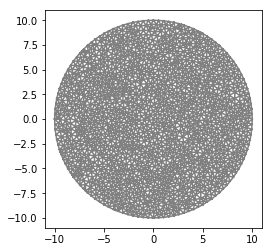

In [127]:
domain = Circle(Point(0.,0.), 10.0, 60)
mymesh = generate_mesh(domain, 30, "cgal")
#mymesh = RectangleMesh(Point(-10,-10), Point(10,10), 20, 20, diagonal='right')
gdim = mymesh.geometry().dim()
tdim = mymesh.topology().dim()

print('Topological dimension: ',tdim)
print('Geometrical dimension: ',gdim)
print('Mesh size: #vertices: '+str(mymesh.num_vertices()) +', #elements: '+str(mymesh.num_cells()) );
plot(mymesh)

# Solve the Bloch-Torrey equation

In [0]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

#################################################################################
#########################  Pre-defined parameters ###############################
mri_para.bvalue = 3000;                              # bvalue (s/mm^2)
mri_para.delta, mri_para.Delta = 10600, 43100        # time sequence (us)
mri_para.set_gradient_dir(mymesh, 0, 1, 0)           # gradient direction

# Some temporal profiles following these references
# Double or Triple Diffusion Encoding:
# # Multidimensional diffusion MRI, https://doi.org/10.1016/j.jmr.2016.12.007
# # Conventions and nomenclature for double diffusion encoding NMR and MRI, https://doi.org/10.1002/mrm.25901
# OGSE https://doi.org/10.1002/mrm.10385

profile = 3
t0 = 0;
Dd = mri_para.Delta+mri_para.delta
seq_ext = 0

if profile==1:
    # PGSE
    mri_para.T = Dd + t0 + seq_ext 
    mri_para.fs_sym = sp.Piecewise(
        (  0., mri_para.s < t0 ),
        (  1., mri_para.s < mri_para.delta + t0),
        (  0., mri_para.s < mri_para.Delta + t0),
        ( -1., mri_para.s < Dd + t0 ),
        (  0.,              True )  
    ) 
    
if profile==2:
    # Double PGSE
    d2seq = mri_para.delta
    disp = Dd + d2seq
    mri_para.T = 2*Dd + t0 + d2seq + seq_ext
    mri_para.fs_sym = sp.Piecewise(
        # period 1
        (  0., mri_para.s < t0 ),
        (  1., mri_para.s < mri_para.delta + t0),
        (  0., mri_para.s < mri_para.Delta + t0),
        ( -1., mri_para.s < Dd + t0 ),

        (  0., mri_para.s < disp),
        # period 2
        (  0., mri_para.s < t0 + disp),
        (  1., mri_para.s < mri_para.delta + t0 + disp),
        (  0., mri_para.s < mri_para.Delta + t0 + disp),
        ( -1., mri_para.s < Dd + t0 + disp),
        (  0.,              True )          
    ) 

if profile==3:
    # cos-OGSE 
    mri_para.T = Dd + t0 + seq_ext
    mri_para.nperiod = 1
    omega = 2.0*mri_para.nperiod*pi/mri_para.delta
    tau = Dd/2.
    mri_para.fs_sym = sp.Piecewise(
        (  0.,                                   mri_para.s < t0 ),        
        (  sp.cos(omega*(mri_para.s-t0)) ,       mri_para.s <= mri_para.delta + t0),
        (  0.,                                   mri_para.s <= tau + t0),
        (  -sp.cos(omega*(mri_para.s-t0-tau)),   mri_para.s <= mri_para.delta + tau + t0),
        (  0.,                                   True )  
    )
if profile==4:
    # sin-OGSE 1 period
    mri_para.T = Dd + t0 + seq_ext
    mri_para.nperiod = 1
    omega = 2.0*mri_para.nperiod*pi/mri_para.delta
    tau = (mri_para.delta + mri_para.Delta)/2.
    mri_para.fs_sym = sp.Piecewise(
        (  0.,                                   mri_para.s < t0 ),                
        (  sp.sin(omega*(mri_para.s-t0)) ,       mri_para.s <= mri_para.delta + t0),
        (  0.,                                   mri_para.s <= tau + t0),
        (  -sp.sin(omega*(mri_para.s-t0-tau)),   mri_para.s <= mri_para.delta + tau + t0),
        (  0.,                                   True )  
    )
if profile==5: 
    # Trapezoid PGSE
    mri_para.T = Dd + t0 + seq_ext 
    tau = mri_para.delta/3. # rise time
    mri_para.fs_sym = sp.Piecewise(
        (  0.,                                  mri_para.s < t0 ),                        
        (  (mri_para.s-t0)/tau,                 mri_para.s < tau + t0),
        (  1.,                                  mri_para.s < mri_para.delta -tau + t0),
        (  -(mri_para.s-t0-mri_para.delta)/tau, mri_para.s < mri_para.delta + t0),
        (  0.,                                  mri_para.s < mri_para.Delta + t0),
        (  -(mri_para.s-t0-mri_para.Delta)/tau, mri_para.s < mri_para.Delta + tau + t0),
        ( -1.,                                  mri_para.s < Dd - tau + t0),
        (  (mri_para.s-t0-Dd)/tau,              mri_para.s < Dd  + t0),
        (  0.,                                  True )  
    )   
  
if profile==6: 
    # Double Trapezoid PGSE
    tau = mri_para.delta/3. # rise time
    d2seq = mri_para.delta
    mri_para.T = 2*Dd + t0 + d2seq + seq_ext
    disp = Dd + d2seq
    mri_para.fs_sym = sp.Piecewise(
        # period 1
        (  0.,                                       mri_para.s < t0 ),                                
        (  (mri_para.s-t0)/tau,                      mri_para.s < tau + t0 ),
        (  1.,                                       mri_para.s < mri_para.delta -tau + t0 ),
        (  -(mri_para.s-t0-mri_para.delta)/tau,      mri_para.s < mri_para.delta + t0 ),
        (  0.,                                       mri_para.s < mri_para.Delta + t0 ),
        (  -(mri_para.s-t0-mri_para.Delta)/tau,      mri_para.s < mri_para.Delta + tau + t0),
        ( -1.,                                       mri_para.s < Dd - tau + t0),
        (  (mri_para.s-t0-Dd)/tau,                   mri_para.s < Dd + t0),

        (  0.,                                       mri_para.s < disp + t0 ),        
        # period 2
        (  (mri_para.s-t0-disp)/tau,                 mri_para.s < tau + t0 + disp ),
        (  1.,                                       mri_para.s < mri_para.delta -tau + t0 + disp),
        (  -(mri_para.s-t0-disp-mri_para.delta)/tau, mri_para.s < mri_para.delta + t0 + disp),
        (  0.,                                       mri_para.s < mri_para.Delta + t0 + disp),
        (  -(mri_para.s-t0-disp-mri_para.Delta)/tau, mri_para.s < mri_para.Delta + tau + t0 + disp),
        ( -1.,                                       mri_para.s < Dd - tau + t0 + disp),
        (  (mri_para.s-t0-disp-Dd)/tau,              mri_para.s < Dd + t0 + disp),
        (  0.,                                       True )  
    )   

plot_time_profile(mri_para)

mri_para.Apply()

mri_simu.k = 200;                                   # time-step size (us)
mri_simu.nskip = 50;                               # frequency to print ouputs
mydomain = MyDomain(mymesh, mri_para)
mydomain.phase = None
mydomain.PeriodicDir = [0, 0, 0];             # Direction of the periodicity
mydomain.IsDomainPeriodic = False             # Confirm if the mesh if periodic
mydomain.IsDomainMultiple = False             # Confirm if the mesh is multiple
mydomain.kappa = 1e-5                         # Permeability (m/s)
################################################################################
mydomain.Apply()   # Call Apply before setting the diffusion tensor
################################################################################
# Impose the diffusion coefficient (mm^2/s)
mydomain.D0 = 3e-3            
mydomain.D = mydomain.D0;
#################################################################################

linsolver = PETScLUSolver("mumps")
mri_simu.solve(mydomain, mri_para, linsolver)

# ctext = 'Disk R=5um, Delta=43.1ms, delta=10.6ms, D=3e-3 mm^2/s, OGSE n=1'
ctext=''
Post_processing(mydomain, mri_para, mri_simu, ctext)
# Post_processing(mydomain, mri_simu,'Extracellular Simulation')

Function Space for Single Domains has 2 components
(ur, ui): r-real, i-imaginary
Initialize a standard function space.
t:   0.00  T: 53700.00 dt: 200.0 gnorm: 3.153419e-04 Completed 0.00%
